# Optimizing Risks for a Portfolio of Cryptocurrencies
> "Introduction into the usage of cvxpy python package"

- author: <a href=http://maximk.com//>Maxim Korotkov</a>, <a href='https://yourdatablog.com/about/'>Dmytro Karabash</a>, <a href='https://www.linkedin.com/in/vladimir-eremin-d/'>Vladimir Eremin</a>
- categories: [treasury, crypto, cvxpy]
- image: images/pixabay-bitcoin-2643159_640.jpg
- permalink: /cryptopt/
- hide: false

In this post we will talk about optimizing a simple portfolio of cryptocurrency. The approaches below have been successfully applied to stock options trading and, as we see, work quite well for crypto. Also, crypto is great to learn and try modern trading strategies as you can get required historical currency data for free (we will show how below). In this post we do a simple portfolio composition and apply CVXP optimization to introduce  library and methods and we will go into more complex Stochastic Discount Factor based strategies in the next post.

You are welcome to open our notebook on colab and see full working code, here we hide some technical parts.

In [ ]:
#hide
#install requirements if needed
!pip install cvxpy==1.0.31 pandas_datareader pandas matplotlib seaborn -q

In [ ]:
#hide
#import modules
import cvxpy as cp
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import math
import os.path
import time

#select plotting style
import matplotlib
import seaborn as sb
matplotlib.style.use('fivethirtyeight')

#seaborn-white  fivethirtyeight
import sys
#Python versiond
print(sys.version)

print(cp.__version__)

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
1.0.31


## Data Acquisition

---

The data for this exercise was obtained from the Binance API using the Python API client `python-binance`. While obtaining similar data for stock market would have been quite a task on its own (unless you work for a trading firm), in crypto worlds it is done easily.

An example of the data acquisition code:
>Note: Install the module if needed using pip:
>#pip install python-binance

```python
from binance.client import Client
binance_api_key = 'YOUR-API-KEY'
binance_api_secret = 'YOUR-API-SECRET'
binance_client = Client(api_key=binance_api_key
				,api_secret=binance_api_secret)
klines = binance_client.get_historical_klines(symbol
				 ,kline_size, date_from, date_to)
data = pd.DataFrame(klines, columns = [COLUMNS])
```

Following daily pairs was downloaded and formatted to pd DataFrame: BTCUSDT; ETHUSDT; BNBUSDT; LTCUSDT.

For each timepoint, Binance provides conventional OHLC (Open, High, Low, Close) and Volume data. In this exercise, we used only the `Close` column. One might consider the combination of all five values and come up with a different (and potentially more reliable) metric, for example: the weighted average price. We will limit to the basic one for the sake of simplicity

The data is loaded and transformed 

In [ ]:
fuldf = (pd.read_csv('https://raw.githubusercontent.com/h17/fastreport/master/data/cryptosdf/data.csv',parse_dates=['timestamp'])
        .set_index('timestamp')
        )
y_label = fuldf.columns[0]
factors = (fuldf
           .columns
            .tolist()
          )


total_size = fuldf.shape[0]

train_set = .8

train_id = int( total_size * train_set)
df_train = fuldf.iloc[:train_id]
df_test = fuldf.iloc[train_id:]
split_index = fuldf.iloc[train_id].name

The joint time-series of four crypto assets looks the following:

In [ ]:
df_train.head()

,BTCUSDT,ETHUSDT,BNBUSDT,LTCUSDT
timestamp,,,,
2017-12-13,16033.29,683.99,2.7190,290.01
2017-12-14,16334.98,679.76,3.1519,272.40
2017-12-15,17539.83,674.95,4.1200,294.00
2017-12-16,19102.66,682.81,4.6378,293.97
2017-12-17,18860.02,707.64,5.9990,311.40


Each trading pair has a different amount of data available: The oldest tradable crypto instruments on Binance are BTCUSDT and ETHUSDT - data points are available from _2017-08-17_. For BNBUSDT and LTCUSDT first trading days are _2017-11-06_ and _2017-12-13_, respectively.

We joined these time series together on the earliest common trading date: _2017-12-13_ up to _2021-06-14_. The full joint dataset size is equal to 1280 samples.

In order to properly train the model, We split the dataset into training and testing sets at _2020-10-02_.

Training interval: _2017-12-13_ to _2020-10-02_ (1024 data points).

Below is the joint plot of the full dataset in the logarithmic scale. The dotted line represents the train-test split at _2020-10-02_

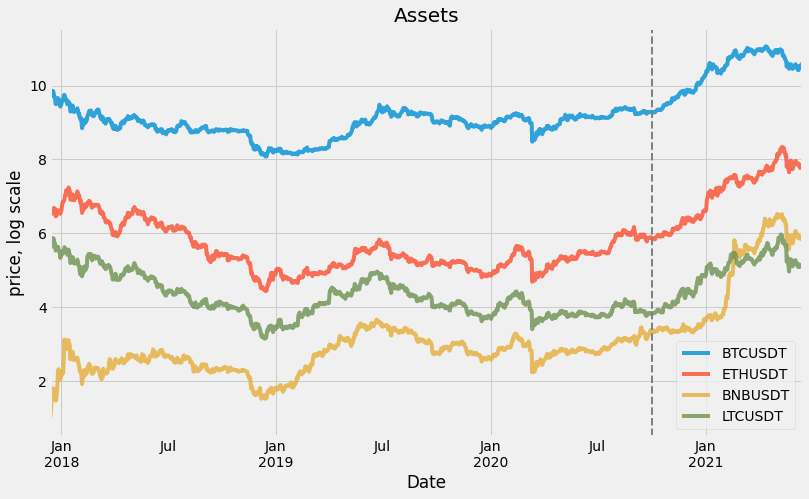

In [ ]:
plot_data =np.log(fuldf)
fig , ax = plt.subplots(figsize=(12,7))
plot_data.plot(ax=ax,alpha=0.8)
ax.legend(loc=0)
ax.set(title='Assets',xlabel='Date',ylabel='price, log scale');

ax.axvline(split_index,color='grey', linestyle='--', lw=2);

In [ ]:
#Transform raw data to log-return format:
lret_data = np.log1p(df_train.pct_change()).dropna(axis=0,how='any')

## II. Data Transformation
---
In order to be properly trained, input time series has to be transfored into the log-return format:

$r_t = \ln{\frac{P_t}{P_{t-1}}}$

Where $P_t$ is a price of the asset at time $t$.

The model needs vector $I$ to perform the optimization: 

$
I = \begin{pmatrix}
r_{0,0} & \dots & r_{0,l} \\ 
\vdots   & & \vdots \\ 
r_{t-1,0} & \dots & r_{t-1,l} 
\end{pmatrix}
$

Where $l$ is the number of features in the model.



In [ ]:

I = (lret_data[factors].iloc[1:].values)

print(I.shape,'\n',I[:10,:])

(1022, 4) 
 [[ 7.11654741e-02 -7.10118064e-03  2.67847718e-01  7.63081931e-02]
 [ 8.53532976e-02  1.15780223e-02  1.18386953e-01 -1.02046023e-04]
 [-1.27832547e-02  3.57188534e-02  2.57352673e-01  5.76005381e-02]
 [-1.99913725e-04  1.02473531e-01  1.66680557e-04  1.22552916e-01]
 [-8.64154176e-02  1.76995771e-02 -5.13108384e-02 -3.91661692e-02]
 [-4.77367274e-02 -9.80986453e-03 -1.01413082e-01 -1.11722790e-01]
 [-6.23272065e-02 -9.91983310e-03  1.82350824e-03 -2.31519865e-03]
 [-1.50602284e-01 -2.07227507e-01 -1.84292643e-01 -1.85013920e-01]
 [-1.99875304e-03  6.84789287e-03  2.50381268e-02  9.71401093e-03]
 [ 1.49256502e-02  2.72056460e-02  1.63393547e-01  3.66466231e-02]]


In [ ]:
F = pd.DataFrame(I)
F.columns = factors#+ [y_label]
F.cov()

,BTCUSDT,ETHUSDT,BNBUSDT,LTCUSDT
BTCUSDT,0.001807,0.001915,0.001840,0.001900
ETHUSDT,0.001915,0.002885,0.002251,0.002488
BNBUSDT,0.001840,0.002251,0.003890,0.002269
LTCUSDT,0.001900,0.002488,0.002269,0.002913


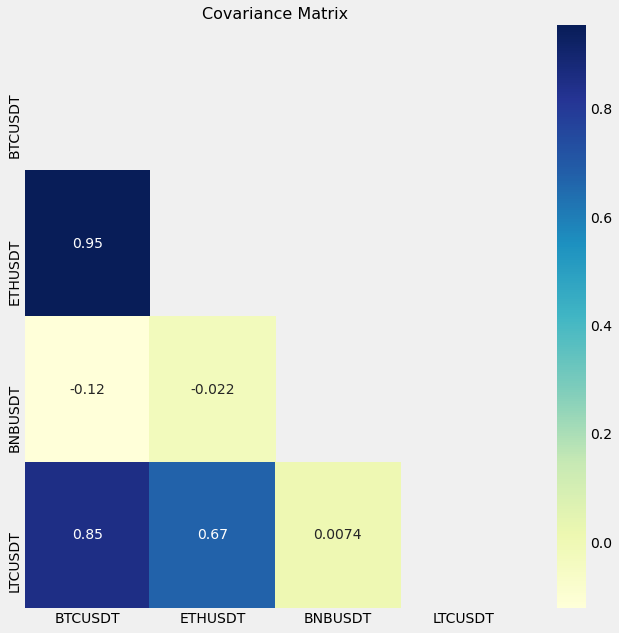

In [ ]:
f = plt.figure(figsize=(10, 10))
cov_data = F.cov()
mask = np.triu(np.ones_like(cov_data))
dataplot = sb.heatmap(cov_data.corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.title('Covariance Matrix', fontsize=16);

## Model 

---

Our goal is to explain the differences in the cross-section of returns $R$ for individual stocks.

Let $I$ denote the return of crypto assets at time $t$.  We try to obtain weights $w$ that minimize risk given fixed return. The portfolio return $R$ can be expressed as follows:

$R = r^Tw$

For this model portfolio, we target a 100% return, which is quite expected in the crypto world.
We will only model investments held for one period.

The problem can be expressed as:

\begin{array}{ll} \mbox{minimize} & \sum||I w ||^2 \\
\mbox{subject to} & {\bf 1}^T w = 1, 1^TR=1
\end{array}


Since the above problem is convex, we can estimate the $w$ for the model portfolio using the `cvxpy` framework.

> Note: in reality, you want to get maximum return given fixed risk, but due to the way CVXP and semi-linear programming is setup, this formulation does not follow Disciplined Convex Programming rules (see https://dcp.stanford.edu/), so we use the former formulation as it is equivalent. Also, you might need fix return and low risk models depending on type of business your are in and your risk appetite.

In [ ]:
#define weights
w = cp.Variable(shape=(I.shape[1]
                        ,1),nonneg=True)

#Define expression
R = I @ w

#Construct the problem
prob = cp.Problem(cp.Minimize( cp.norm(R) )
                 , [ cp.sum(R) == 1 
                    ,cp.sum(w) == 1
                    ]
                  
                )
prob.solve(verbose=True)

print('weights for the model:\n',dict(zip(factors,w.value)))


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +4e+01  5e-01  5e-02  1e+00  7e+00    ---    ---    1  1  - |  -  - 
 1  -3.010e-01  -3.110e-01  +3e+00  5e-02  3e-03  6e-02  5e-01  0.9292  3e-04   2  2  2 |  0  0
 2  +1.454e+00  +1.482e+00  +5e-01  9e-03  4e-04  4e-02  8e-02  0.9115  9e-02   2  2  2 |  0  0
 3  +1.577e+00  +1.579e+00  +2e-02  4e-04  2e-05  2e-03  4e-03  0.9680  1e-02   2  1  1 |  0  0
 4  +1.583e+00  +1.583e+00  +2e-03  4e-05  2e-06  2e-04  4e-04  0.9049  2e-03   2  1  1 |  0  0
 5  +1.584e+00  +1.584e+00  +2e-04  5e-06  2e-07  3e-05  5e-05  0.9579  9e-02   2  1  1 |  0  0
 6  +1.584e+00  +1.584e+00  +1e-05  2e-07  1e-08  2e-06  2e-06  0.9506  2e-04   2  1  1 |  0  0
 7  +1.584e+00  +1.584e+00  +5e-07  1e-08  4e-10  8e-08  1e-07  0.9890  3e-02   2  1  1 |  0  0
 8  +1.584e+00  +1.584e+00  +5e-09  1e-10  5e-

In [ ]:
def sharpe(x):
  return (x.mean() / x.std() * np.sqrt(365))

def calc_metrics(data):
  p_return = ((data[factors].pct_change().fillna(0))
              .apply(lambda x: (x @ w.value)[0] ,axis =1)
              .rename('Model Portfolio')
              )
  returns = data.pct_change().fillna(0)
  returns['Model Portfolio'] = p_return
  sharpes = returns.apply(np.log1p).apply(sharpe)
  pnls = (returns.apply(np.log1p).sum().apply(np.expm1)).apply(lambda x:f'{100*x:4.2f}%')
  result = pd.concat([sharpes,pnls],axis=1)
  result.columns='sharpes pnls'.split()
  return result

def plot_return(data,title):
  datac = data.copy()
  fig , ax = plt.subplots(figsize=(13,5))

  y_return = (datac[factors].pct_change().fillna(0)+1)
  
  p_return = ((datac[factors].pct_change().fillna(0) + 1)
              .apply(lambda x: (x @ w.value)[0] ,axis =1)
              .rename('Model Portfolio')
              )
  
  
  
  p_return_c = p_return.cumprod()
  y_return_c = y_return.cumprod()
  portfolio_benchmark = pd.concat([y_return_c,p_return_c],axis=1)

  #change to the log scale 
  portfolio_benchmark = np.log1p(portfolio_benchmark)
  portfolio_benchmark[factors].plot(ax=ax,alpha=.5)
  portfolio_benchmark['Model Portfolio'].plot(ax=ax,alpha=.7,color='black')
  ax.legend(loc=0)
  ax.set(title=title,ylabel='growth factor',xlabel='date')
  
  return portfolio_benchmark

## Results
Below is the result of computing the Model Portfolio on the training dataset and plotting it against the index portfolio (BTCUSDT):

In [ ]:
calc_metrics(df_train)

,sharpes,pnls
BTCUSDT,-0.180999,-33.77%
ETHUSDT,-0.230150,-48.41%
BNBUSDT,0.690628,910.20%
LTCUSDT,-0.634821,-84.05%
Model Portfolio,0.502973,284.22%


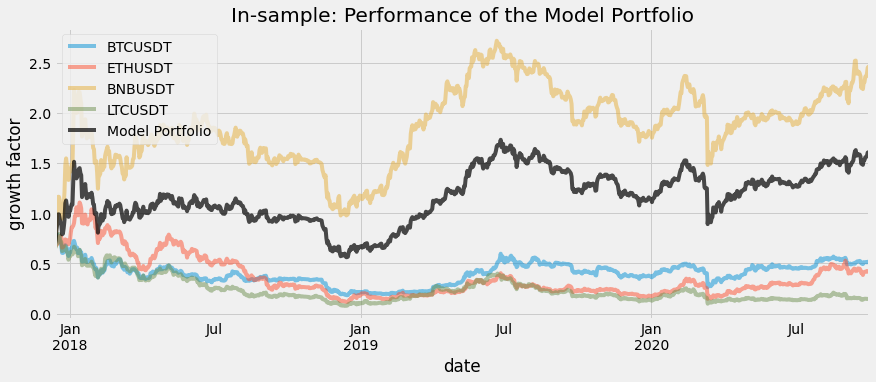

In [ ]:
portfolio_benchmark = plot_return(df_train,'In-sample: Performance of the Model Portfolio')

Resulted plot and metrics for the hold-out dataset:

In [ ]:
calc_metrics(df_test)

,sharpes,pnls
BTCUSDT,2.300239,283.89%
ETHUSDT,2.505201,640.02%
BNBUSDT,2.404085,1263.87%
LTCUSDT,1.455977,289.51%
Model Portfolio,2.754792,784.81%


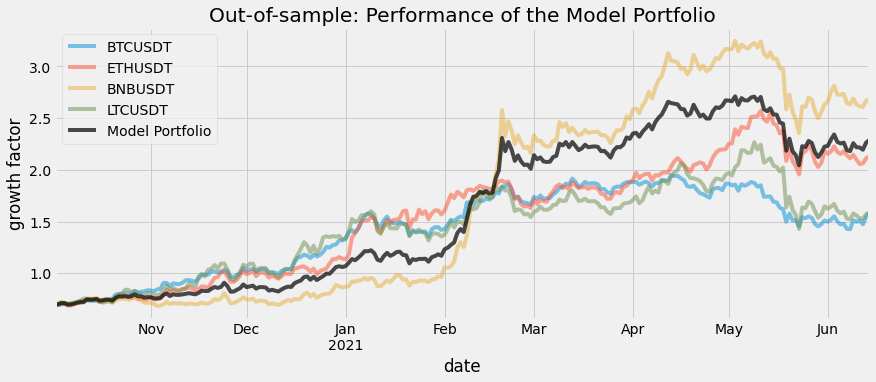

In [ ]:
portfolio_benchmark_ho = plot_return(df_test,'Out-of-sample: Performance of the Model Portfolio')

## Conclusion
---
In this exercise, we fixed return of our portfolio and minimized the risk - we get better sharp than any of the coins and performance between best and second best performing coin.

> Disclaimer:&nbsp; authors of this paper do not use these methods for any investments and do not recommend to use this paper for investment. It is just for demonstration purposes of the CVXP.  The material presented here is done without a backtest, daily simulation or cutting-edge libraries.  We would recommend to use MOSEK library and more rigorous approach.